In [124]:
"""
GP emulation: packages are pip or conda installable

!pip install sklearn
!pip install gpy

"""
##### Packages ###############

from sklearn.decomposition import PCA
import GPy
import pickle

import numpy as np
import time

import matplotlib.pylab as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from itertools import cycle

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  

In [125]:
############################# PARAMETERS ##############################

dataDir = "./Data/" ## Data folder
modelDir = "./Models/" ## Data folder
plotsDir = "./Plots/" ## Data folder

nRankMax = [4, 8, 12, 16, 32][2]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

del_idx = [7, 20, 14, 40]  ## Random holdouts (not used in training, reserved for validation) 


############################# PARAMETERS ##############################

paramIn = dataDir + 'mg.design'
fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]

In [126]:
loadFile = np.loadtxt(fileIn)

PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]


parameter_array_all = np.loadtxt(paramIn)


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)

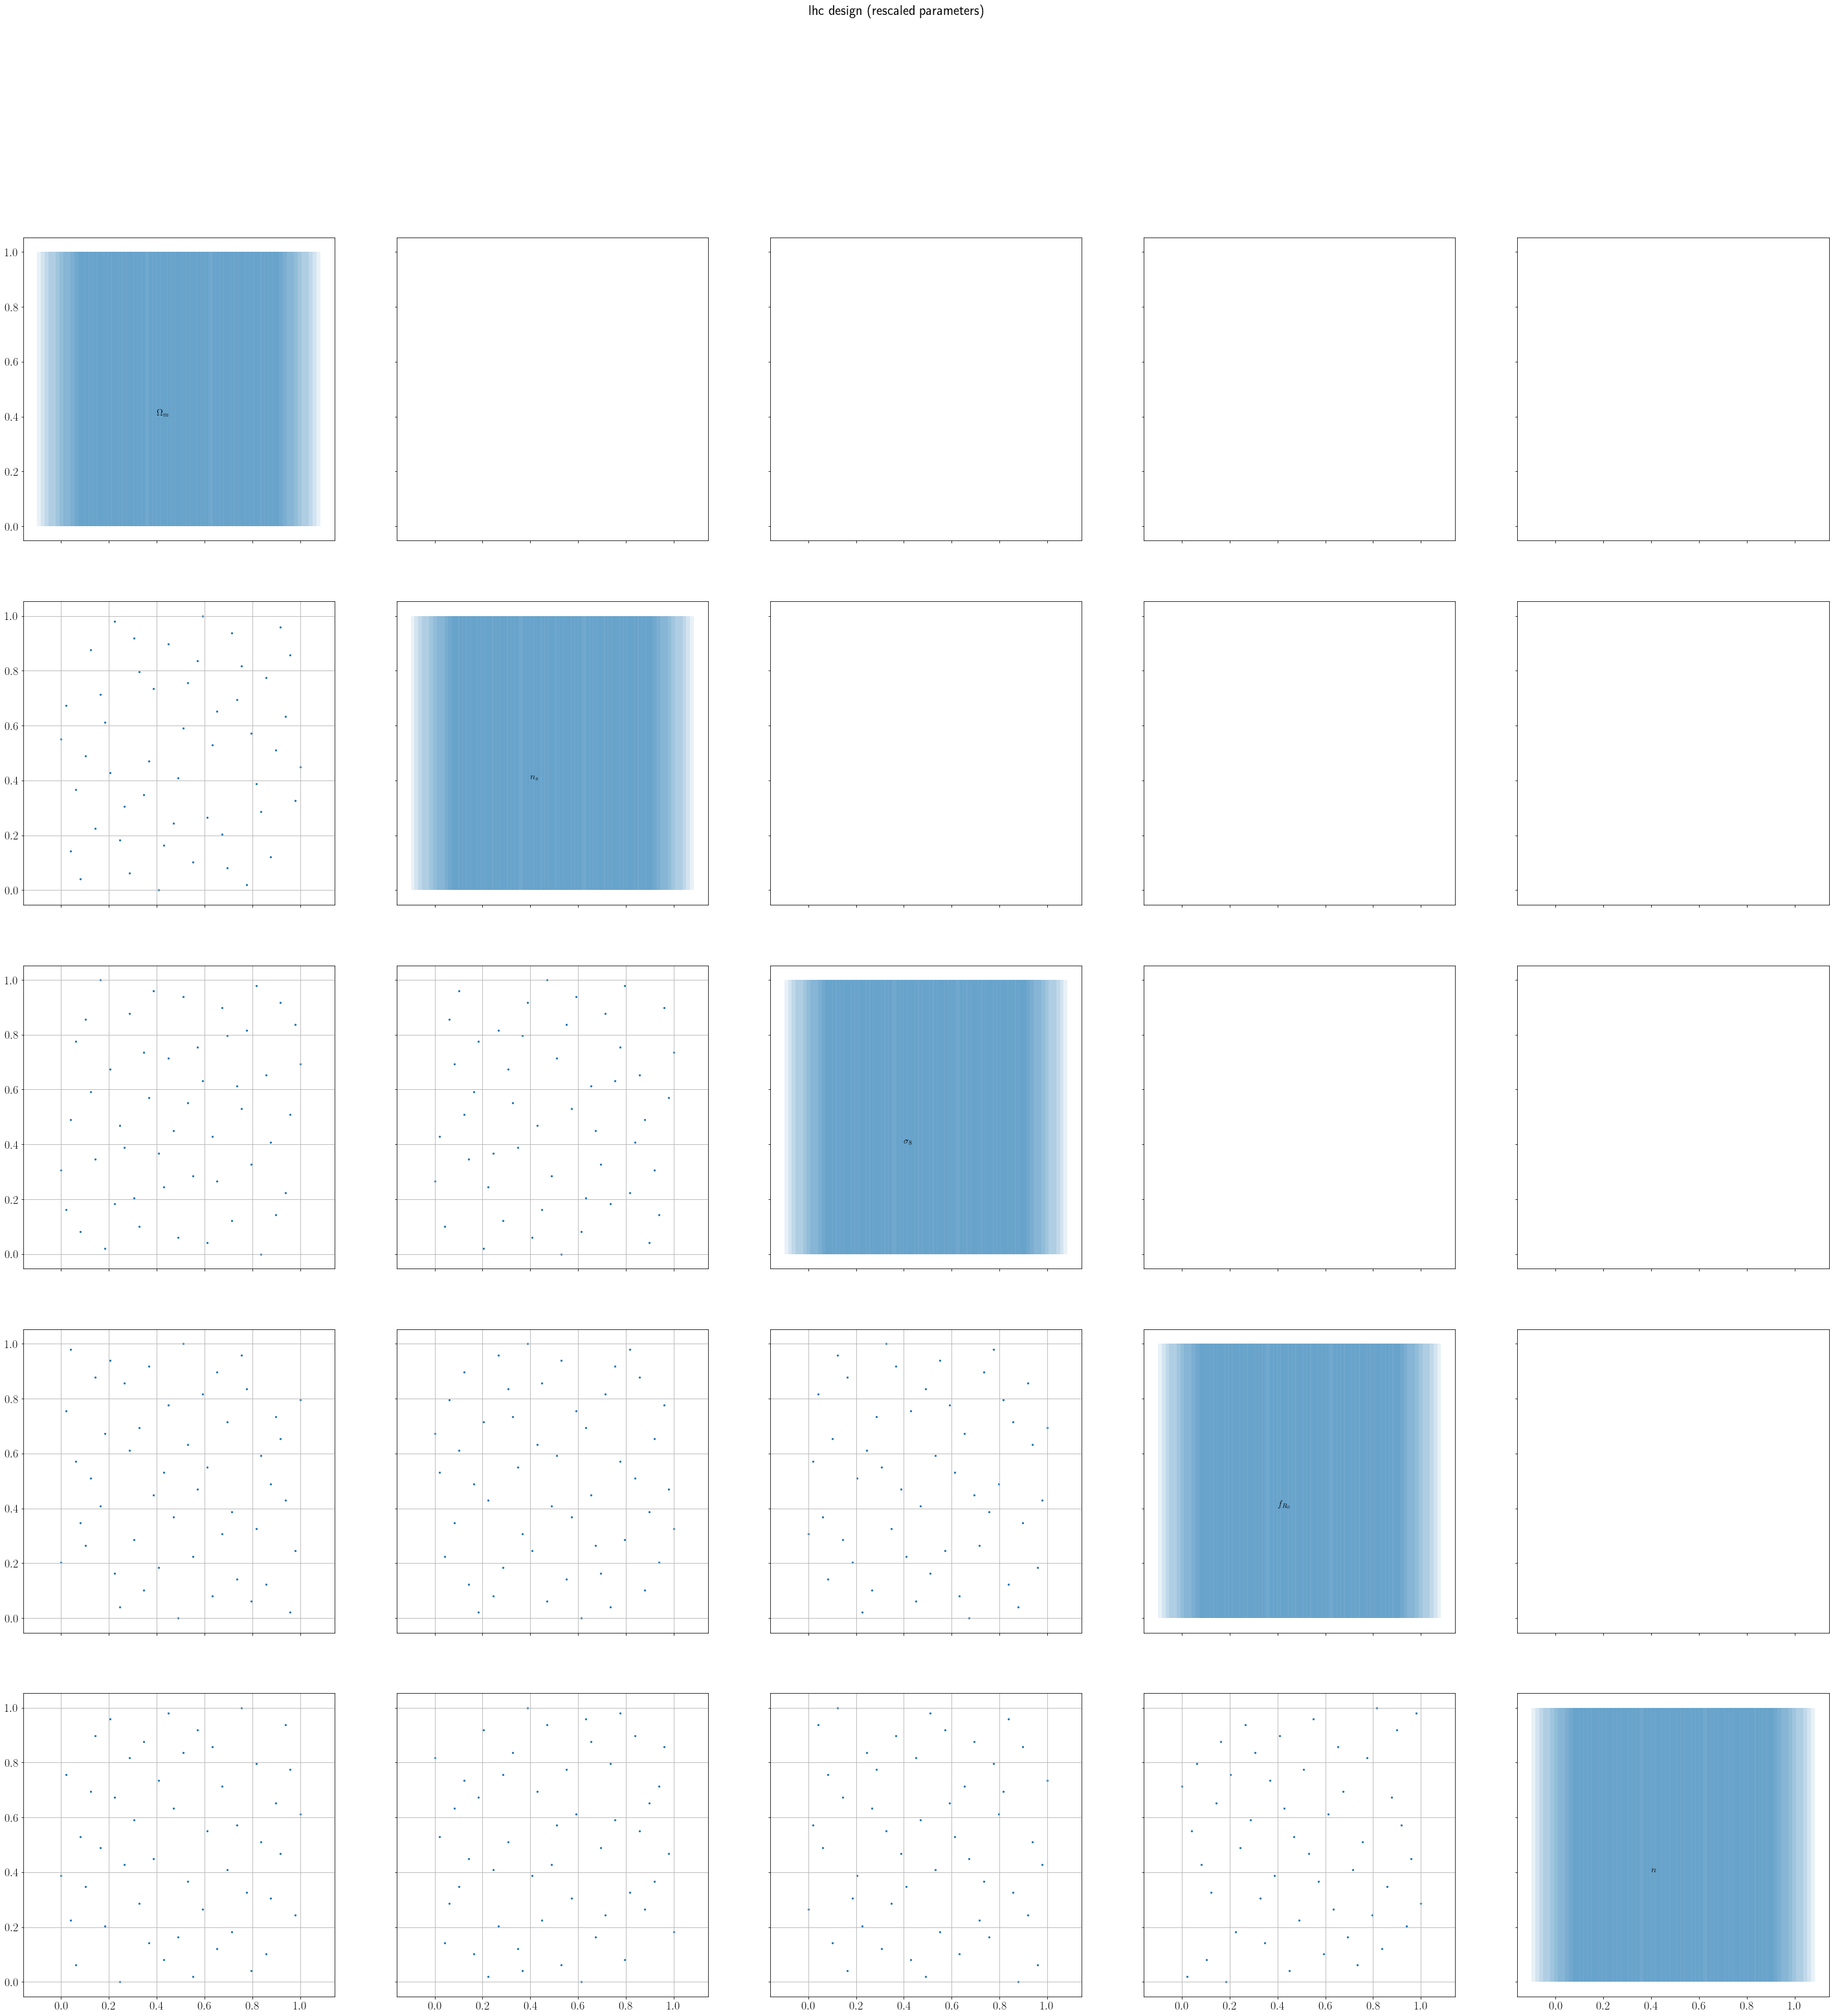

In [127]:
allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(50,50) )
    plt.suptitle('lhc design (rescaled parameters)')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [128]:
######################## GP PREDICTION FUNCTIONS ###############################

def GPy_predict(para_array):
    m1p = m1.predict(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded[0]

    else:
        W_predArray, _ = GPy_predict(para_array)
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded.T

 /anaconda3/envs/env_rpy/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning:Trying to unpickle estimator PCA from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.


sample emulated value: [1.03298905 1.05662142 1.07072493 1.0985666  1.12350187 1.13177977
 1.15757625 1.18245953 1.20404553 1.23438968 1.26652491 1.29223751
 1.31901315 1.3333968  1.33621577 1.31835124 1.2901679  1.26256525
 1.24195471 1.23147863]
Time per emulation 0.0005  s
Time per emulation 0.0004  s
Time per emulation 0.0004  s
Time per emulation 0.0003  s


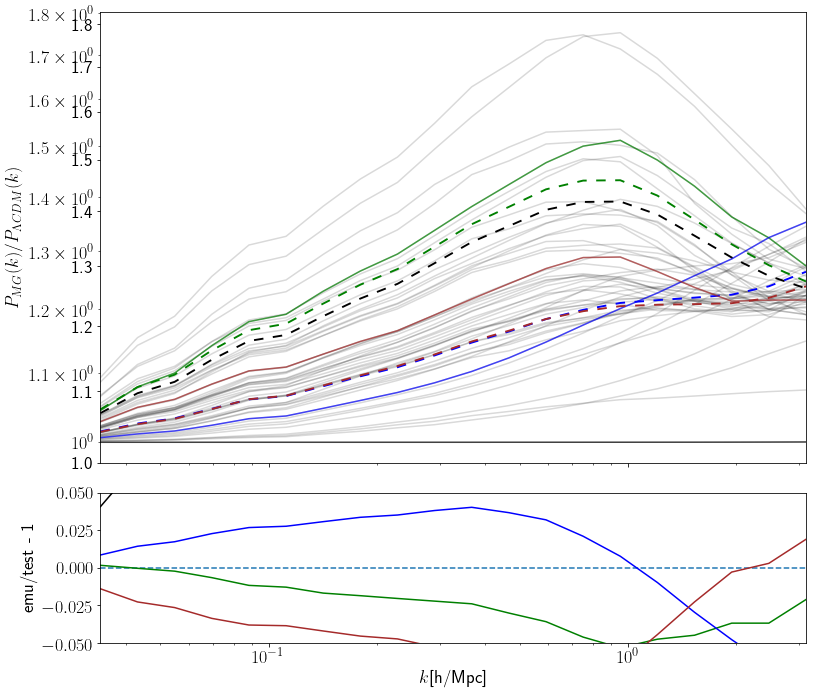

In [129]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

## Both models below have to be loaded -- one for GP and one for PCA
m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model' + str(nRankMax) + '.zip')
pca_model = pickle.load(open(modelDir + 'PCA_model' + str(nRankMax), 'rb'))


## Calling the Emulator function with 5 arguements [Om, ns, sigma8, fR0, n]

print('sample emulated value:', Emu(np.array([1, 1, 1, 1, 1]) ) )
print(50*'=')

#########################################################

colorList = ['r', 'g', 'k', 'b', 'brown']

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually




plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
ax1.set_xlabel(r'$k$[h/Mpc]')
ax1.axhline(y=0, ls='dashed')

ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'emu/test - 1')

ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')


ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])
ax1.set_ylim(-5e-2, 5e-2)


color_id = 0
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
    x_decodedGPy = Emu(parameter_array_all[x_id])  ## input parameters
    time1 = time.time()
    print('Time per emulation %0.4f' % (time1 - time0), ' s')
    x_test = PmPl_all[x_id]

    ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=colorList[color_id])
    ax0.plot(kvals, x_test, alpha=0.7, label='test', color=colorList[color_id])
    ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=colorList[color_id])
    
start, end = ax0.get_ylim()
ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'MGemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()



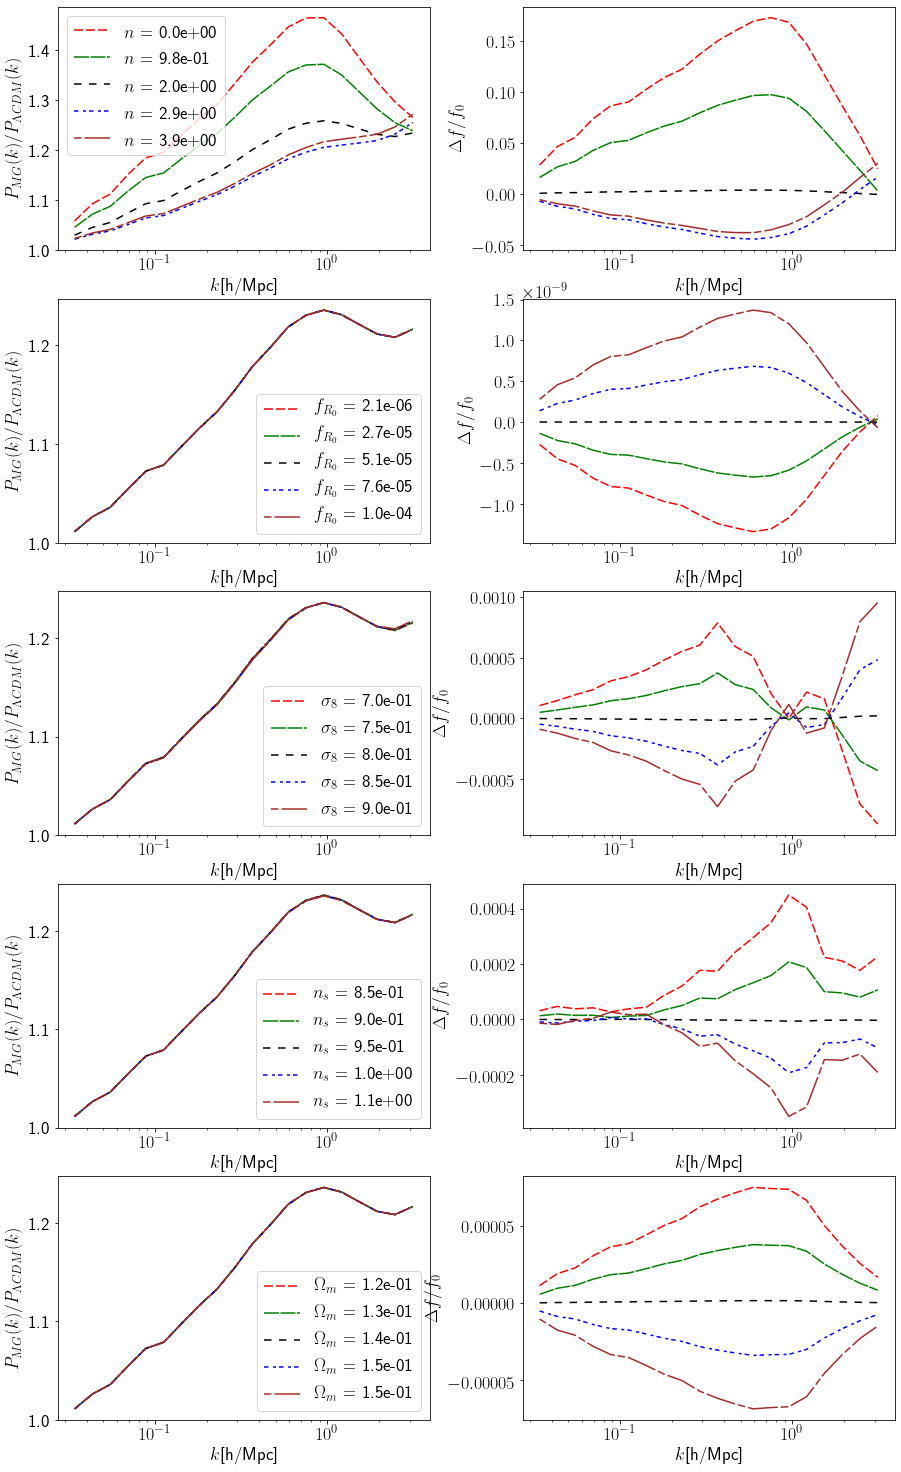

In [130]:

numPlots = 5

allMax = np.max(parameter_array, axis = 0)
allMin = np.min(parameter_array, axis = 0)
allMean = np.mean(parameter_array, axis = 0)


Pk_mean = Emu(allMean) 


fig, ax = plt.subplots(5,2, figsize = (15,26))
plt.subplots_adjust(wspace=0.25)

for paramNo in range(5):
    para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

    lines = ["-","-.","--",":"]
    linecycler = cycle(lines)
    dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
    colorList = ['r', 'g', 'k', 'b', 'brown']


    for plotID in range(numPlots):
        para_plot = np.copy(allMean)
        para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!
        x_decodedGPy = Emu(para_plot) 
        lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

        ax[4-paramNo,0].set_xscale('log')
        ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
        ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')

        ax[4-paramNo,0].set_yticks([], minor = True)
        ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
        ax[4-paramNo,0].legend()

        ax[4-paramNo,1].set_xscale('log')
        ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
        ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

        ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


    start, end = ax[4-paramNo, 0].get_ylim()
    ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
    ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()


In [131]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


In [99]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [132]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x = kvals
y = Emu(para_plot)#/(Pk_mean) - 1 

p = figure(title="simple line example", plot_height=500, plot_width=600, y_range=(1,1.6),
           background_fill_color='white')

r = p.line(x, y, color='black', line_width=1.5, alpha=0.8)

p1min, p2min, p3min, p4min, p5min = parameter_array_all.min(axis = 0)
p1max, p2max, p3max, p4max, p5max = parameter_array_all.max(axis = 0)
p1mean, p2mean, p3mean, p4mean, p5mean = parameter_array_all.mean(axis = 0)


def update(p1=p1mean , p2= p2mean, p3=p3mean, p4=p4mean, p5=p5mean):
#     if   f == "sin": func = np.sin
#     elif f == "cos": func = np.cos
    r.data_source.data['y'] = Emu(np.array([p1, p2, p3, 10**p4, p5]))#/Pk_mean - 1
    push_notebook()
    
show(p, notebook_handle=True)

interact(update, p1=(p1min,p1max), p2=(p2min,p2max), p3=(p3min, p3max), p4 = (np.log10(p4min), np.log10(p4max)), p5 = (p5min, p5max))

Loading BokehJS ...

interactive(children=(FloatSlider(value=0.13749999944, description='p1', max=0.155, min=0.12), FloatSlider(val…

<function __main__.update(p1=0.13749999944, p2=0.9499999936800002, p3=0.79999998638, p4=5.00050011078e-05, p5=2.0000000657080004)>